In [2]:
import cv2
import qrcode
import os
import numpy as np
import random
import requests
import json
from PIL import Image
from io import BytesIO
from matplotlib import pyplot as plt
import shutil
from sklearn.model_selection import train_test_split

In [4]:
# Directory setup
os.makedirs("../data/model_training/images", exist_ok=True)
os.makedirs("../data/model_training/labels", exist_ok=True)

def load_api_key(file_path="../config.txt"):
    """Load the API key from a text file."""
    try:
        with open(file_path, "r") as file:
            for line in file:
                if line.startswith("BING_API_KEY"):
                    return line.strip().split("=")[1]
        raise ValueError("API key not found in config file.")
    except FileNotFoundError:
        raise FileNotFoundError(f"Config file not found at: {file_path}")

In [60]:
def scrape_and_save_images(query, count, save_dir, min_size=(640, 640), retries=10):
    """
    Scrape background images using the Bing API and save them locally.
    Filters out images that are smaller than the specified size.

    Args:
        query (str): Search query for the images.
        count (int): Number of images to download.
        save_dir (str): Directory to save the images.
        min_size (tuple): Minimum size (width, height) for the images.
        retries (int): Number of retry attempts for scraping.
    """
    api_key = load_api_key()
    if not api_key:
        raise ValueError("API key not found or invalid.")

    os.makedirs(save_dir, exist_ok=True)
    url = "https://api.bing.microsoft.com/v7.0/images/search"
    headers = {"Ocp-Apim-Subscription-Key": api_key}
    params = {"q": query, "count": count, "imageType": "photo", "license": "public"}

    total_downloaded = 0
    for attempt in range(retries):
        try:
            response = requests.get(url, headers=headers, params=params)
            response.raise_for_status()
            results = response.json().get("value", [])
            if results:
                for result in results:
                    image_url = result["contentUrl"]
                    try:
                        # Download and open the image
                        image_data = requests.get(image_url).content
                        img = Image.open(BytesIO(image_data))

                        # Check image size
                        if img.size[0] >= min_size[0] and img.size[1] >= min_size[1]:
                            img = img.resize(min_size)  # Resize to ensure minimum size
                            img_path = os.path.join(save_dir, f"{query}_{total_downloaded}.jpg")
                            img.save(img_path)
                            print(f"Saved: {img_path}")
                            total_downloaded += 1
                            if total_downloaded >= count:
                                return
                    except Exception as e:
                        print(f"Error processing image: {e}")
        except Exception as e:
            print(f"Error during API call (attempt {attempt + 1}/{retries}): {e}")

    print(f"Downloaded {total_downloaded} images out of {count} requested.")

# Scrape images and save them
scrape_and_save_images("hills", count=100, save_dir="../data/backgrounds")
scrape_and_save_images("forest", count=100, save_dir="../data/backgrounds")
scrape_and_save_images("shooting_range", count=100, save_dir="../data/backgrounds")
scrape_and_save_images("landscape", count=100, save_dir="../data/backgrounds")
scrape_and_save_images("yard", count=100, save_dir="../data/backgrounds")

Saved: ../data/backgrounds/hills_0.jpg
Saved: ../data/backgrounds/hills_1.jpg
Saved: ../data/backgrounds/hills_2.jpg
Saved: ../data/backgrounds/hills_3.jpg
Error processing image: cannot identify image file <_io.BytesIO object at 0x159ea2430>
Error processing image: cannot identify image file <_io.BytesIO object at 0x11744f6f0>
Error processing image: cannot identify image file <_io.BytesIO object at 0x11744f6f0>
Saved: ../data/backgrounds/hills_4.jpg
Error processing image: cannot identify image file <_io.BytesIO object at 0x117ef1b20>
Saved: ../data/backgrounds/hills_5.jpg
Error processing image: cannot identify image file <_io.BytesIO object at 0x159ea3b00>
Error processing image: cannot identify image file <_io.BytesIO object at 0x1598e24d0>
Saved: ../data/backgrounds/hills_6.jpg
Error processing image: cannot identify image file <_io.BytesIO object at 0x117ef1b20>
Error processing image: cannot identify image file <_io.BytesIO object at 0x159de6ca0>
Error processing image: cannot 

[{'x_center': 192.03346252441406, 'y_center': 192.0366668701172, 'width': 302.06693, 'height': 302.06046}, {'x_center': 2356.134765625, 'y_center': 3106.0048828125, 'width': 300.2693, 'height': 303.07593}, {'x_center': 2335.5068359375, 'y_center': 212.39137268066406, 'width': 343.01343, 'height': 342.78275}, {'x_center': 171.420654296875, 'y_center': 3128.712646484375, 'width': 260.8413, 'height': 263.4253}]


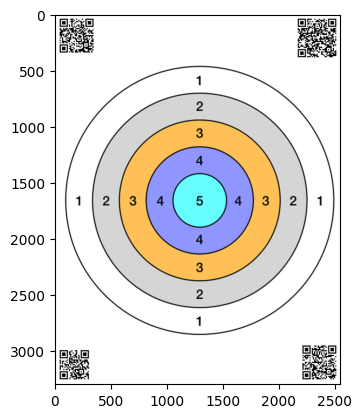

In [5]:
target_path = "../data/targets/output/scoring_target_qr_5.jpg"

def detect_qr_code_centers(image_path):
    """Detect QR code centers and bounding boxes on the target image."""
    image = cv2.imread(image_path)
    plt.imshow(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    qr_detector = cv2.QRCodeDetector()
    data, _, vertices, _ = qr_detector.detectAndDecodeMulti(image)

    if vertices is None:
        raise ValueError("No QR codes detected on the target image!")

    qr_data = []
    for v in vertices:
        x_center = (v[0][0] + v[2][0]) / 2  # Average x of top-left and bottom-right
        y_center = (v[0][1] + v[2][1]) / 2  # Average y of top-left and bottom-right
        width = v[2][0] - v[0][0]
        height = v[2][1] - v[0][1]
        qr_data.append({"x_center": x_center, "y_center": y_center, "width": width, "height": height})
    return qr_data

qr_codes = detect_qr_code_centers(target_path)
print(qr_codes)

[{'x_center': 2973.55712890625, 'y_center': 2224.05810546875, 'width': 509.1145, 'height': 508.1162}, {'x_center': 324.0581359863281, 'y_center': 324.0581359863281, 'width': 508.11627, 'height': 508.11627}, {'x_center': 2974.124267578125, 'y_center': 324.124267578125, 'width': 522.24854, 'height': 522.24854}, {'x_center': 324.4464416503906, 'y_center': 2225.59423828125, 'width': -493.10712, 'height': 495.18823}]


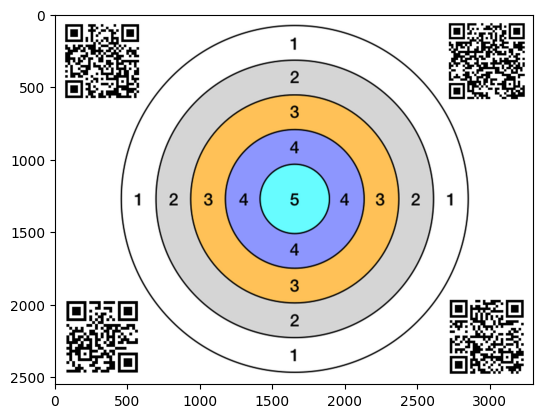

In [6]:
target_path = "../data/targets/output/scoring_target_qr_5_h.jpg"

def detect_qr_code_centers(image_path):
    """Detect QR code centers and bounding boxes on the target image."""
    image = cv2.imread(image_path)
    plt.imshow(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    qr_detector = cv2.QRCodeDetector()
    data, _, vertices, _ = qr_detector.detectAndDecodeMulti(image)

    if vertices is None:
        raise ValueError("No QR codes detected on the target image!")

    qr_data = []
    for v in vertices:
        x_center = (v[0][0] + v[2][0]) / 2  # Average x of top-left and bottom-right
        y_center = (v[0][1] + v[2][1]) / 2  # Average y of top-left and bottom-right
        width = v[2][0] - v[0][0]
        height = v[2][1] - v[0][1]
        qr_data.append({"x_center": x_center, "y_center": y_center, "width": width, "height": height})
        
    return qr_data

qr_codes = detect_qr_code_centers(target_path)
print(qr_codes)

# Image Augmentations to Diversify Dataset

In [94]:
def random_brightness_contrast(image):
    alpha = np.random.uniform(0.5, 1.5)  # Contrast
    beta = np.random.uniform(-50, 50)    # Brightness
    return cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

def random_perspective_warp(image, max_shift=0.1):
    """
    Apply a random perspective warp to an image and make out-of-bounds areas transparent.

    Args:
        image (ndarray): The input image (grayscale or color).
        max_shift (float): Maximum shift percentage for the warp.

    Returns:
        warped_image (ndarray): The warped image with transparency.
        mask (ndarray): A mask indicating the valid (non-transparent) regions.
        matrix (ndarray): The transformation matrix used for the warp.
    """
    h, w = image.shape[:2]
    src_pts = np.float32([[0, 0], [w, 0], [w, h], [0, h]])
    dst_pts = np.float32([
        [np.random.uniform(0, w * max_shift), np.random.uniform(0, h * max_shift)],
        [np.random.uniform(w * (1 - max_shift), w), np.random.uniform(0, h * max_shift)],
        [np.random.uniform(w * (1 - max_shift), w), np.random.uniform(h * (1 - max_shift), h)],
        [np.random.uniform(0, w * max_shift), np.random.uniform(h * (1 - max_shift), h)]
    ])
    matrix = cv2.getPerspectiveTransform(src_pts, dst_pts)
    
    # Warp the image
    warped_image = cv2.warpPerspective(image, matrix, (w, h), borderValue=0)
    
    # Create a mask for non-transparent (valid) areas
    mask = cv2.warpPerspective(np.ones_like(image, dtype=np.uint8), matrix, (w, h), borderValue=0)
    
    return warped_image, mask, matrix


def adjust_qr_codes_for_warp(qr_codes, warp_matrix):
    """
    Adjust QR code positions based on the perspective warp matrix.

    Args:
        qr_codes (list): List of QR codes with positions and sizes.
        warp_matrix (ndarray): Transformation matrix for warping.

    Returns:
        adjusted_qr_codes (list): QR codes with updated positions after warp.
    """
    adjusted_qr_codes = []
    for qr_code in qr_codes:
        x_center, y_center = qr_code["x_center"], qr_code["y_center"]
        width, height = qr_code["width"], qr_code["height"]

        # Transform QR code corner points
        corners = np.array([
            [x_center - width / 2, y_center - height / 2],
            [x_center + width / 2, y_center - height / 2],
            [x_center + width / 2, y_center + height / 2],
            [x_center - width / 2, y_center + height / 2]
        ], dtype="float32")
        transformed_corners = cv2.perspectiveTransform(corners[None, :, :], warp_matrix)[0]

        # Calculate new bounding box
        x_min, y_min = transformed_corners.min(axis=0)
        x_max, y_max = transformed_corners.max(axis=0)
        new_x_center = (x_min + x_max) / 2
        new_y_center = (y_min + y_max) / 2
        new_width = x_max - x_min
        new_height = y_max - y_min

        adjusted_qr_codes.append({
            "x_center": new_x_center,
            "y_center": new_y_center,
            "width": new_width,
            "height": new_height
        })

    return adjusted_qr_codes

def add_random_occlusion(image, qr_size=500):
    """
    Add random occlusions scaled relative to the size of the QR code.

    Args:
        image (ndarray): The QR code image.
        qr_size (int): The size of the QR code (width or height).
    """
    h, w = image.shape[:2]
    num_occlusions = np.random.randint(5, 20)  # Add 1-5 occlusions

    for _ in range(num_occlusions):
        shape_type = random.choice(["rectangle", "circle", "ellipse"])
        color = random.choice([0, 255])  # Black or white

        if shape_type == "rectangle":
            # Rectangle occlusion, scaled to QR size
            rect_w = np.random.randint(qr_size // 5, qr_size // 2)
            rect_h = np.random.randint(qr_size // 5, qr_size // 2)
            x1 = np.random.randint(0, w - rect_w)
            y1 = np.random.randint(0, h - rect_h)
            cv2.rectangle(image, (x1, y1), (x1 + rect_w, y1 + rect_h), color, -1)

        elif shape_type == "circle":
            # Circle occlusion, scaled to QR size
            radius = np.random.randint(qr_size // 10, qr_size // 4)
            center = (np.random.randint(radius, w - radius), np.random.randint(radius, h - radius))
            cv2.circle(image, center, radius, color, -1)

        elif shape_type == "ellipse":
            # Ellipse occlusion, scaled to QR size
            axes = (np.random.randint(qr_size // 10, qr_size // 4), np.random.randint(qr_size // 10, qr_size // 4))
            center = (np.random.randint(axes[0], w - axes[0]), np.random.randint(axes[1], h - axes[1]))
            angle = np.random.randint(0, 360)
            cv2.ellipse(image, center, axes, angle, 0, 360, color, -1)

    return image

def augment_image(target, qr_codes):
    """
    Apply augmentations to the target image and adjust QR codes.

    Args:
        target (ndarray): Target image to be augmented.
        qr_codes (list): List of QR codes with positions and sizes.

    Returns:
        augmented_target (ndarray): Augmented target image.
        augmented_qr_codes (list): Adjusted QR codes.
        mask (ndarray): Transparency mask for the augmented target.
    """
    mask = np.ones_like(target, dtype=np.uint8)
    if random.choice([True, False]):
        target = random_brightness_contrast(target)
    if random.choice([True, False]):
        target, mask, warp_matrix = random_perspective_warp(target)
        qr_codes = adjust_qr_codes_for_warp(qr_codes, warp_matrix)
    if random.choice([True, False]):
        target = add_random_occlusion(target)
    return target, qr_codes, mask

def add_gaussian_blur(image):
    """Apply light Gaussian blur."""
    return cv2.GaussianBlur(image, (3, 3), 0)

def simulate_distance_effect(image, target_width, target_height, scale_factor, max_blur=1):
    """
    Simulate the effect of an image being further back in real life.

    Args:
        image (ndarray): Input image to be downsized.
        target_width (int): Desired width of the output image.
        target_height (int): Desired height of the output image.
        blur_intensity (int): Gaussian blur kernel size to simulate depth.

    Returns:
        downsized (ndarray): Downsized and blurred image.
    """
    # get blur intensity from scale_factor
    blur_intensity = int(scale_factor * max_blur * 2 + 1)
    blur_intensity = blur_intensity if blur_intensity % 2 == 1 else blur_intensity + 1

    # Resize the image using Lanczos interpolation
    downsized = cv2.resize(image, (target_width, target_height), interpolation=cv2.INTER_LANCZOS4)

    # Apply a light Gaussian blur to simulate depth
    if blur_intensity > 0:
        downsized = cv2.GaussianBlur(downsized, (blur_intensity * 2 + 1, blur_intensity * 2 + 1), 0)

    return downsized

def scale_target_image(target, qr_codes, bg_w, min_scale=0.05, max_scale=0.3):
    """
    Scale the target image and adjust QR codes accordingly.

    Args:
        target (ndarray): Target image to be scaled.
        qr_codes (list): List of QR codes with positions and sizes.
        bg_w (int): Width of the background image.
        min_scale (float): Minimum scaling ratio.
        max_scale (float): Maximum scaling ratio.

    Returns:
        scaled_target (ndarray): Scaled target image.
        scaled_qr_codes (list): Adjusted QR codes.
        scale_factor (float): Scaling factor applied to the target image.
    """
    scale_factor = np.random.uniform(min_scale, max_scale)
    target_h, target_w = target.shape
    scale_factor_qr = scale_factor * (bg_w / target_w)
    ratio = target_h / target_w
    new_h = int((ratio * bg_w) * scale_factor)
    new_w = int(bg_w * scale_factor)

    # Scale the target image
    scaled_target = simulate_distance_effect(target, new_w, new_h, scale_factor)

    # Adjust the QR codes
    scaled_qr_codes = []
    for qr_code in qr_codes:
        scaled_x_center = qr_code["x_center"] * scale_factor_qr
        scaled_y_center = qr_code["y_center"] * scale_factor_qr
        scaled_width = qr_code["width"] * scale_factor_qr
        scaled_height = qr_code["height"] * scale_factor_qr
        scaled_qr_codes.append({
            "x_center": scaled_x_center,
            "y_center": scaled_y_center,
            "width": scaled_width,
            "height": scaled_height
        })

    return scaled_target, scaled_qr_codes, scale_factor

def detect_qr_code_centers(image_path):
    """Detect QR code centers and bounding boxes on the target image."""
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    qr_detector = cv2.QRCodeDetector()
    data, _, vertices, _ = qr_detector.detectAndDecodeMulti(image)

    if vertices is None:
        raise ValueError("No QR codes detected on the target image!")

    qr_data = []
    for v in vertices:
        x_center = (v[0][0] + v[2][0]) / 2  # Average x of top-left and bottom-right
        y_center = (v[0][1] + v[2][1]) / 2  # Average y of top-left and bottom-right
        width = v[2][0] - v[0][0]
        height = v[2][1] - v[0][1]
        qr_data.append({"x_center": x_center, "y_center": y_center, "width": width, "height": height})
    return qr_data

def overlay_label_points(image_path, labels):
    """
    Overlay red dots on the image at the QR code label locations.

    Args:
        image_path (str): Path to the image file.
        labels (list): List of labels in YOLO format [class_id, x_center, y_center, width, height].
    """
    # Load the image
    image = cv2.imread(image_path)
    h, w = image.shape[:2]

    # Draw red dots
    for label in labels:
        _, x_center_norm, y_center_norm, _, _ = label
        x_center = int(x_center_norm * w)
        y_center = int(y_center_norm * h)
        cv2.circle(image, (x_center, y_center), radius=5, color=(0, 0, 255), thickness=-1)

    # Display the image
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

In [96]:
#background_images = "../data/backgrounds/"
# Directory where background images are saved
background_dir = "../data/backgrounds"
output_dir = "../data/model_training"

# Load all background image paths into a list
background_images = [
    os.path.join(background_dir, img)
    for img in os.listdir(background_dir)
    if img.endswith(('.png', '.jpg', '.jpeg'))  # Include common image formats
]

# Tunable Parameters
canvas_size = (800, 800)
dataset_size = 5000
qr_codes = detect_qr_code_centers(target_path)

# Generate dataset
for i in range(dataset_size):
    qr_codes_i = qr_codes.copy()

    # Randomly select a background image
    bg_path = random.choice(background_images)
    background = cv2.imread(bg_path, cv2.IMREAD_GRAYSCALE)
    background = cv2.resize(background, canvas_size)
    bg_h, bg_w = background.shape

    # Load the target image
    target = cv2.imread(target_path, cv2.IMREAD_GRAYSCALE)

    # Apply augmentations
    target, qr_codes_i, mask = augment_image(target, qr_codes_i)

    # Scale the target image
    target, qr_codes_i, scale_factor = scale_target_image(target, qr_codes_i, bg_w)

    # Validate that the target fits within the background
    target_h, target_w = target.shape
    if target_h > bg_h or target_w > bg_w:
        print(f"Skipping iteration {i}: Target too large for background.")
        continue

    # Randomly position the target on the background
    x_offset = np.random.randint(0, bg_w - target_w)
    y_offset = np.random.randint(0, bg_h - target_h)

    # Overlay the target on the background
    mask = cv2.resize(mask, (target.shape[1], target.shape[0]), interpolation=cv2.INTER_NEAREST)
    target_region = background[y_offset:y_offset + target_h, x_offset:x_offset + target_w]
    target_region[mask > 0] = target[mask > 0]
    background[y_offset:y_offset + target_h, x_offset:x_offset + target_w] = target_region

    # Adjust QR code positions for final placement
    labels = []
    for qr_code in qr_codes_i:
        final_x_center = qr_code["x_center"] + x_offset
        final_y_center = qr_code["y_center"] + y_offset

        # Normalize for YOLO format
        x_center_norm = final_x_center / bg_w
        y_center_norm = final_y_center / bg_h
        width_norm = qr_code["width"] / bg_w
        height_norm = qr_code["height"] / bg_h
        labels.append([0, x_center_norm, y_center_norm, width_norm, height_norm])

    # Save the image
    img_path = f"{output_dir}/images/qr_code_{i}.png"
    cv2.imwrite(img_path, background)

    # Save the labels
    label_path = f"{output_dir}/labels/qr_code_{i}.txt"
    with open(label_path, "w") as f:
        for label in labels:
            f.write(" ".join(map(str, label)) + "\n")

    # Optional: Visualize labels
    if False:
        overlay_label_points(
            image_path=img_path,
            labels=labels
        )

    print(f"Generated: {img_path}")

Generated: ../data/model_training/images/qr_code_0.png
Generated: ../data/model_training/images/qr_code_1.png
Generated: ../data/model_training/images/qr_code_2.png
Generated: ../data/model_training/images/qr_code_3.png
Generated: ../data/model_training/images/qr_code_4.png
Generated: ../data/model_training/images/qr_code_5.png
Generated: ../data/model_training/images/qr_code_6.png
Generated: ../data/model_training/images/qr_code_7.png
Generated: ../data/model_training/images/qr_code_8.png
Generated: ../data/model_training/images/qr_code_9.png
Generated: ../data/model_training/images/qr_code_10.png
Generated: ../data/model_training/images/qr_code_11.png
Generated: ../data/model_training/images/qr_code_12.png
Generated: ../data/model_training/images/qr_code_13.png
Generated: ../data/model_training/images/qr_code_14.png
Generated: ../data/model_training/images/qr_code_15.png
Generated: ../data/model_training/images/qr_code_16.png
Generated: ../data/model_training/images/qr_code_17.png
Ge

In [97]:
# Define paths
source_images_dir = "../data/model_training/images"
source_labels_dir = "../data/model_training/labels"
destination_base_dir = os.path.expanduser("~/Library/yolov5/dataset")

# Define destination paths
dest_images_train = os.path.join(destination_base_dir, "images/train")
dest_images_val = os.path.join(destination_base_dir, "images/val")
dest_labels_train = os.path.join(destination_base_dir, "labels/train")
dest_labels_val = os.path.join(destination_base_dir, "labels/val")

# Create destination directories
os.makedirs(dest_images_train, exist_ok=True)
os.makedirs(dest_images_val, exist_ok=True)
os.makedirs(dest_labels_train, exist_ok=True)
os.makedirs(dest_labels_val, exist_ok=True)

# Get all image filenames
image_files = [f for f in os.listdir(source_images_dir) if f.endswith(".png")]

# Split dataset into 80% train and 20% validation
train_images, val_images = train_test_split(image_files, test_size=0.2, random_state=42)

# Function to copy files
def copy_files(file_list, src_dir, dest_dir, extension):
    for file_name in file_list:
        base_name = os.path.splitext(file_name)[0]  # Get file name without extension
        src_file = os.path.join(src_dir, f"{base_name}{extension}")
        dest_file = os.path.join(dest_dir, f"{base_name}{extension}")
        if os.path.exists(src_file):
            shutil.copy(src_file, dest_file)

# Copy train files
copy_files(train_images, source_images_dir, dest_images_train, ".png")
copy_files(train_images, source_labels_dir, dest_labels_train, ".txt")

# Copy validation files
copy_files(val_images, source_images_dir, dest_images_val, ".png")
copy_files(val_images, source_labels_dir, dest_labels_val, ".txt")

print("Dataset split completed.")

Dataset split completed.


In [92]:
!rm -rf ../data/model_training/*